In [14]:
import numpy as np
import numpy.matlib as ml
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.utils import resample
import seaborn as sns


In [15]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

In [16]:
import os
import FUNC_Stable3_GasSphere_ElasticShellViscFlesh as vefunc

# Fixed Parameters
Most parameters are fixed for Limacina

In [46]:
M_order=3

ro1=1027    # Surronding Water density  "kg/m³"
ro2=1040  # Surronding viscouis layer (fish flesh) density  "kg/m³"
ro3=2717  # Elastic sphere Density "kg/m³"
ro4=3315.2  # Inner Gas Sphere Density "kg/m³"

c1=1462    # Surronding Water speed of sound "m/s" @ 4,3deg 31,2 PSU
c2=1523    # Surronding viscouis layer (fish flesh) speed of sound "m/s"
#c3=1480    # Elastic sphere speed of sound "m/s"
c4=2721.55    # gas speed of sound "m/s"

Eta2=2*0.428572
Mu2=Eta2
Kisi2=Mu2+4*Eta2/3
    
Mu3=35800*1.0E6  # "N/m²" shear rigidity of elastic shell
Landa3=2.4*1E9  # "N/m²" Compressional rigidity of elastic shell

c3=(ro3/(Landa3+2*Mu3))**-0.5    # Elastic sphere speed of sound "m/s"


In [47]:
# set fixed values
params_lima ={'ro1':ro1,
            'ro2':ro2,
            'ro3':ro3,
            'ro4':ro4,
            'c1':c1,
            'c2':c2,
            'c3':c3,
            'c4':c4,
            'Eta2':Eta2,
            'Mu3':Mu3,
            'Landa3':Landa3,
            'Kisi2':Kisi2}

## Variable Parameters
For these model simulations the only variable with distribution is the **SHAPE.**

The main variable parameter is R3- the radius of the swimbladder including the wall. In the case of Limacina it is the whole measured length (or calculated width).

The other two variable parameters are R4- radius of the swimbladder (R3-thickness of swimbladder wall) and R2-radius of fish fesh, since there is not flesh around the shell in a Limacina, we use R4=R3.

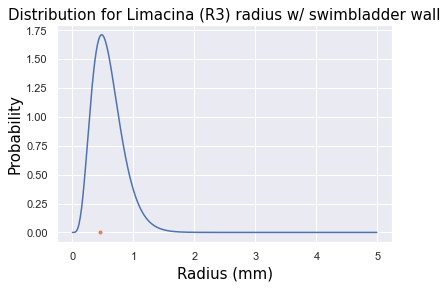

In [48]:
# Radius R3 distribution
# Values from lengthDist.Rmd. scale is 1/rate. shape is alpha. 
# radius distribution was calculated using all measured lengths (divided by 2!) and their associated widths(Divided by 2!) (L/a=1.5 Stanton 2000)
x=np.arange(0,5,0.01)
R3_dist = stats.gamma.pdf(x,a=5.4,scale=1/9.17)

plt.plot(x,R3_dist)
plt.plot(np.random.gamma(5.4,1/9.17),0, '.')
plt.title('Distribution for Limacina (R3) radius w/ swimbladder wall', title_font)
plt.xlabel('Radius (mm)', axis_font)
plt.ylabel('Probability', axis_font);

## Set up simulation

In [49]:
# Frequency range
min_freq=100*1000
max_freq=600*1000
frequencySpacing=500
Freq_vec=np.arange(min_freq,max_freq,frequencySpacing) 

## Run ensembles

In [56]:
nsim = 1000
nfreqs = len(Freq_vec)

# Allocate space for speed
R3_ensemble = np.zeros((nsim,1))
R4_ensemble = np.zeros((nsim,1))
TS_simulations = np.zeros((nsim*nfreqs))
freqs=np.zeros((nsim*nfreqs))

for ind_sim in np.arange(nsim):
    
    # Set new radius parameters
    R3 = np.random.gamma(5.4,1/4.6)*1e-3
    params_lima['R3'] = R3
    params_lima['R2'] = R3
    params_lima['R4'] = R3  - (R3*0.023) 
    
    # Run the v-e model
    print('Running simulations for SB radius %.2f mm, simulation %.0f' %(R3*1000,ind_sim))
    TS_vec_lima = vefunc.run_ve(Freq_vec, M_order, params_lima)
    
    # Save each iterated radius values
    R3_ensemble[ind_sim] = R3
    R4_ensemble[ind_sim] = params_lima['R4']

    # Save all results.
    TS_simulations[ind_sim*nfreqs:ind_sim*nfreqs+nfreqs] = TS_vec_lima
    freqs[ind_sim*nfreqs:ind_sim*nfreqs+nfreqs] = Freq_vec

Running simulations for SB radius 2.10 mm, simulation 0
Running simulations for SB radius 1.95 mm, simulation 1
Running simulations for SB radius 0.84 mm, simulation 2
Running simulations for SB radius 1.00 mm, simulation 3
Running simulations for SB radius 0.91 mm, simulation 4
Running simulations for SB radius 0.92 mm, simulation 5
Running simulations for SB radius 1.50 mm, simulation 6
Running simulations for SB radius 0.83 mm, simulation 7
Running simulations for SB radius 1.94 mm, simulation 8
Running simulations for SB radius 0.39 mm, simulation 9
Running simulations for SB radius 1.31 mm, simulation 10
Running simulations for SB radius 1.68 mm, simulation 11
Running simulations for SB radius 0.75 mm, simulation 12
Running simulations for SB radius 1.01 mm, simulation 13
Running simulations for SB radius 0.62 mm, simulation 14
Running simulations for SB radius 1.55 mm, simulation 15
Running simulations for SB radius 0.92 mm, simulation 16
Running simulations for SB radius 0.84 mm

Running simulations for SB radius 2.07 mm, simulation 144
Running simulations for SB radius 1.83 mm, simulation 145
Running simulations for SB radius 0.37 mm, simulation 146
Running simulations for SB radius 0.68 mm, simulation 147
Running simulations for SB radius 0.80 mm, simulation 148
Running simulations for SB radius 1.18 mm, simulation 149
Running simulations for SB radius 1.99 mm, simulation 150
Running simulations for SB radius 0.67 mm, simulation 151
Running simulations for SB radius 1.15 mm, simulation 152
Running simulations for SB radius 1.46 mm, simulation 153
Running simulations for SB radius 0.88 mm, simulation 154
Running simulations for SB radius 1.17 mm, simulation 155
Running simulations for SB radius 0.82 mm, simulation 156
Running simulations for SB radius 0.82 mm, simulation 157
Running simulations for SB radius 1.14 mm, simulation 158
Running simulations for SB radius 0.46 mm, simulation 159
Running simulations for SB radius 1.58 mm, simulation 160
Running simula

Running simulations for SB radius 0.98 mm, simulation 286
Running simulations for SB radius 0.77 mm, simulation 287
Running simulations for SB radius 2.03 mm, simulation 288
Running simulations for SB radius 0.92 mm, simulation 289
Running simulations for SB radius 1.44 mm, simulation 290
Running simulations for SB radius 2.11 mm, simulation 291
Running simulations for SB radius 1.27 mm, simulation 292
Running simulations for SB radius 1.35 mm, simulation 293
Running simulations for SB radius 1.12 mm, simulation 294
Running simulations for SB radius 1.32 mm, simulation 295
Running simulations for SB radius 1.43 mm, simulation 296
Running simulations for SB radius 1.13 mm, simulation 297
Running simulations for SB radius 1.73 mm, simulation 298
Running simulations for SB radius 1.48 mm, simulation 299
Running simulations for SB radius 2.52 mm, simulation 300
Running simulations for SB radius 0.57 mm, simulation 301
Running simulations for SB radius 2.17 mm, simulation 302
Running simula

Running simulations for SB radius 1.49 mm, simulation 428
Running simulations for SB radius 0.92 mm, simulation 429
Running simulations for SB radius 1.33 mm, simulation 430
Running simulations for SB radius 0.61 mm, simulation 431
Running simulations for SB radius 1.52 mm, simulation 432
Running simulations for SB radius 0.45 mm, simulation 433
Running simulations for SB radius 1.13 mm, simulation 434
Running simulations for SB radius 2.13 mm, simulation 435
Running simulations for SB radius 0.27 mm, simulation 436
Running simulations for SB radius 1.21 mm, simulation 437
Running simulations for SB radius 1.77 mm, simulation 438
Running simulations for SB radius 0.40 mm, simulation 439
Running simulations for SB radius 0.51 mm, simulation 440
Running simulations for SB radius 2.12 mm, simulation 441
Running simulations for SB radius 1.03 mm, simulation 442
Running simulations for SB radius 2.04 mm, simulation 443
Running simulations for SB radius 1.25 mm, simulation 444
Running simula

Running simulations for SB radius 0.50 mm, simulation 570
Running simulations for SB radius 1.45 mm, simulation 571
Running simulations for SB radius 1.48 mm, simulation 572
Running simulations for SB radius 1.56 mm, simulation 573
Running simulations for SB radius 0.94 mm, simulation 574
Running simulations for SB radius 1.94 mm, simulation 575
Running simulations for SB radius 1.66 mm, simulation 576
Running simulations for SB radius 1.71 mm, simulation 577
Running simulations for SB radius 1.07 mm, simulation 578
Running simulations for SB radius 0.86 mm, simulation 579
Running simulations for SB radius 1.60 mm, simulation 580
Running simulations for SB radius 0.54 mm, simulation 581
Running simulations for SB radius 0.68 mm, simulation 582
Running simulations for SB radius 0.93 mm, simulation 583
Running simulations for SB radius 0.79 mm, simulation 584
Running simulations for SB radius 1.87 mm, simulation 585
Running simulations for SB radius 0.84 mm, simulation 586
Running simula

Running simulations for SB radius 1.57 mm, simulation 712
Running simulations for SB radius 1.03 mm, simulation 713
Running simulations for SB radius 1.49 mm, simulation 714
Running simulations for SB radius 1.66 mm, simulation 715
Running simulations for SB radius 0.64 mm, simulation 716
Running simulations for SB radius 0.66 mm, simulation 717
Running simulations for SB radius 2.05 mm, simulation 718
Running simulations for SB radius 0.81 mm, simulation 719
Running simulations for SB radius 1.52 mm, simulation 720
Running simulations for SB radius 1.53 mm, simulation 721
Running simulations for SB radius 1.05 mm, simulation 722
Running simulations for SB radius 0.57 mm, simulation 723
Running simulations for SB radius 1.69 mm, simulation 724
Running simulations for SB radius 1.23 mm, simulation 725
Running simulations for SB radius 0.39 mm, simulation 726
Running simulations for SB radius 1.00 mm, simulation 727
Running simulations for SB radius 1.45 mm, simulation 728
Running simula

Running simulations for SB radius 0.42 mm, simulation 854
Running simulations for SB radius 1.25 mm, simulation 855
Running simulations for SB radius 1.06 mm, simulation 856
Running simulations for SB radius 1.30 mm, simulation 857
Running simulations for SB radius 1.18 mm, simulation 858
Running simulations for SB radius 1.28 mm, simulation 859
Running simulations for SB radius 0.99 mm, simulation 860
Running simulations for SB radius 0.97 mm, simulation 861
Running simulations for SB radius 1.31 mm, simulation 862
Running simulations for SB radius 0.89 mm, simulation 863
Running simulations for SB radius 1.65 mm, simulation 864
Running simulations for SB radius 1.19 mm, simulation 865
Running simulations for SB radius 0.87 mm, simulation 866
Running simulations for SB radius 1.05 mm, simulation 867
Running simulations for SB radius 0.76 mm, simulation 868
Running simulations for SB radius 1.92 mm, simulation 869
Running simulations for SB radius 2.30 mm, simulation 870
Running simula

Running simulations for SB radius 2.32 mm, simulation 996
Running simulations for SB radius 1.36 mm, simulation 997
Running simulations for SB radius 0.56 mm, simulation 998
Running simulations for SB radius 1.53 mm, simulation 999


In [57]:
# Repeat R3 array to match TS and freqs
R3_sims = ml.repmat(R3_ensemble,1, nfreqs)
R3_simulations = R3_sims.reshape(-1)

## Create dataframe for results

In [58]:
ve_simdata=pd.DataFrame({'freqs':freqs/1000,'TS_lima':TS_simulations, 'R3 (mm)': R3_simulations*1000})

# Plot results
Colour is used to indicated the effect of shape (Limacina radius at the angle of incidence) on the frequency response.

(100.0, 600.0)

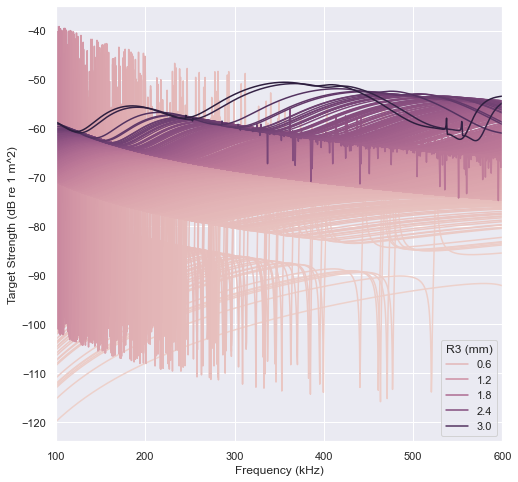

In [59]:
plt.figure(figsize=(8,8))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_lima',hue='R3 (mm)')
plt.ylabel('Target Strength (dB re 1 m^2)')
plt.xlabel('Frequency (kHz)')
plt.xlim([100, 600])

(185.0, 383.0)

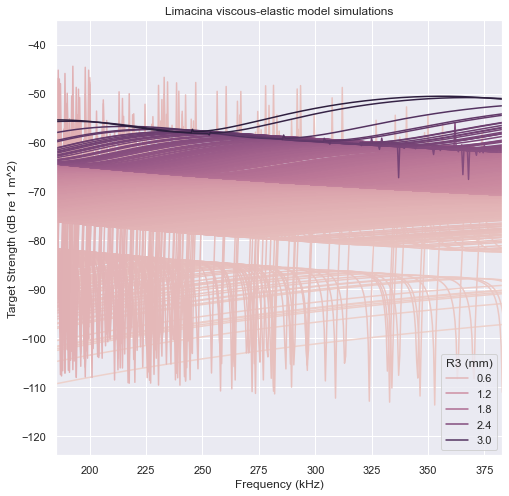

In [60]:
plt.figure(figsize=(8,8))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_lima',hue='R3 (mm)')
plt.ylabel('Target Strength (dB re 1 m^2)')
plt.xlabel('Frequency (kHz)')
plt.title('Limacina viscous-elastic model simulations')
plt.xlim([185, 383])

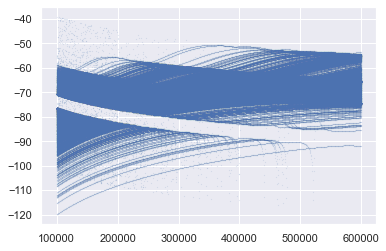

In [61]:
F_TS_MAT=np.concatenate((freqs.reshape(-1,1),TS_simulations.reshape(-1,1)),axis=1)
plt.plot(F_TS_MAT[:,0],F_TS_MAT[:,1], '.', markersize=0.1)

## Write to file
Write the results in a text file with a header of parameters and a row for each frequency and TS.

Should I add R3?

In [62]:
# uncomment when ready.
vefunc.write_ve('./ve_results/ve_simulations_limacina.txt', M_order, params_lima, F_TS_MAT)

In [28]:
ve_simdata['sigbs'] = 10**(ve_simdata['TS_lima']/10)
mean_bs = ve_simdata.groupby(["freqs"]).agg({'sigbs':'mean'})

Text(0.5, 1.0, 'Limacina')

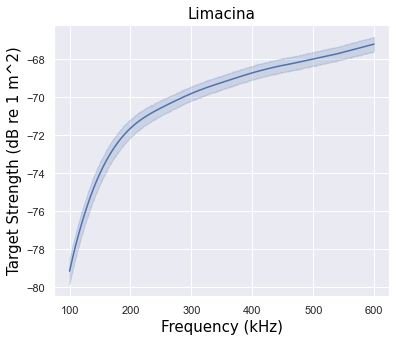

In [29]:
plt.figure(figsize=(6,5))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_lima')
plt.ylabel('Target Strength (dB re 1 m^2)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Limacina', title_font)

In [30]:
simulations=ve_simdata
n_boots=100
percentiles=(2.5, 97.5)
# First, calculate mean for each frequency of the whole sample
mean_bs = simulations.groupby(['freqs']).mean()['sigbs']


# Resample , calculate mean repeat n_boot times, then calculate the SPREAD of the MEANS.
sigbs = simulations.sigbs
freq = simulations.freqs
freqs = np.unique(freq)

# Create our empty array to fill the results
ci_boot = np.zeros([2, len(freqs)])

# Resample over each frequency
for i in range(len(freqs)):
    sigbs_selectfreq = sigbs[freq==freqs[i]]

    # Create our empty array to fill the results              
    bootstrap_means = np.zeros([n_boots])

    # Resample within the values of the selected frequency and calculate the mean
    for ii in range(n_boots):
    # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(sigbs_selectfreq)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Save the percentiles of the bootstraped means for the selected frequency
    ci_boot[:,i] = np.percentile(bootstrap_means, percentiles, axis=0)

Text(0.5, 1.0, 'Limacina')

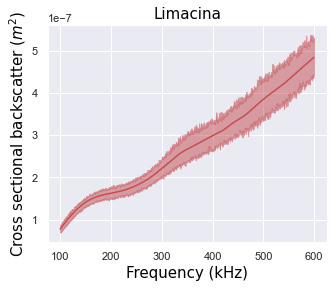

In [31]:
plt.figure(figsize=(5,4))
plt.plot(freqs, mean_bs, 'r')
plt.fill_between(freqs, ci_boot[0,:], ci_boot[1,:], alpha=0.5, color='r')
plt.ylabel('Cross sectional backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Limacina', title_font)